<a href="https://colab.research.google.com/github/omid-taghipour/Social-Media-Analythics/blob/main/portfolio2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing  Libraries

# Project Overview
## Introduction
In our increasingly connected world, the rise of hate speech sharing has become a pressing concern. The digital world, with its vast amount of communication channels, has given way to new forms of harassment and intimidation. This project aims to benefit from the power of Natural Language Processing (NLP) and machine learning to predict instances of hate speech. Moreover, exploration of the unique words and patterns embedded in the language of hate speech will be embarked on to better understand this problem's nature and characteristics.

## Goal of the Project
Goal of the project is to investigate Natural Language Processing (NLP) methodologies to identify hate speech. As well as identifying hate speech, we tend to investigate the linguistic aspects of the hate speech to understand deeper nature and characteristics of this topic.

## Methodology
### 1. Data
During this project, we will use the [`Hate Speech Detection curated Dataset🤬`](https://www.kaggle.com/datasets/waalbannyantudre/hate-speech-detection-curated-dataset) available on the Kaggle repository for the people to use. Dataset has been already neutralized to remove information about the people to follow privacy right of the people. The original dataset is available at [Mendely website](https://data.mendeley.com/datasets/9sxpkmm8xn/1). Additionally, the dataset has been used in the [**A curated dataset for hate speech detection on social media text** article](https://www.sciencedirect.com/science/article/pii/S2352340922010356) that focused on hate speech recognition also. Further information about the characteristics of the dataset will be given in the corresponding section of the project.
#### Dataset Citation
Mody, Devansh; Huang, YiDong; Alves de Oliveira, Thiago Eustaquio (2022), “A Curated Hate Speech Dataset”, Mendeley Data, V1, doi: 10.17632/9sxpkmm8xn.1
### 2. Data Preprocessing
Like all other data science projects there will be data preprocessing to reshape data into a form that can be understood by the machine learning models better.

### 3. Sentiment Analysis
As first step of this project, we will implement sentiment analysis. Sentiment analysis calculates polarity score of the text. Calculated scores identify if text is positive, neutral, or negative. We expect the result of sentiment analysis to be negative for texts labeled as hate speech and positive for texts labeled as not hate speech.

### 4. Topic Modeling

### 5. Classification using Machine Learning
As the last step of this project, we will investigate classification using machine learning models. We will implement two different machine learning models and tune their parameters. After training models, each model will be tested individually with the test dataset. Results of the models' prediction will be used in evaluation of models.

## Significance
Understanding and predicting hate speech is crucial for fostering a safer online environment. By developing an accurate model and uncovering linguistic patterns, we can contribute to the ongoing efforts to mitigate the impact of hate speech, protect individuals from harm, and promote positive digital interactions

> *Note: This part served as an introduction to our NLP project. Subsequent sections will delve into the technical details, results, and implications of our work.*.

# Installing required libraries

In [1]:
!pip install contractions
!pip install sentencepiece
!pip install pyLDAvis
!pip install swifter
!pip install tqdm

# Importing libraries

In [2]:
from google.colab import drive
from tqdm import tqdm
import torch
import pandas as pd
import matplotlib.pyplot as plt
import re
import contractions
import swifter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
import concurrent.futures
import numpy as np
from scipy.special import softmax
from transformers import AutoTokenizer, XLMRobertaTokenizer, AutoConfig, AutoModelForSequenceClassification
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import gensim
from gensim import corpora

In [3]:
drive.mount('/content/drive')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Controller variables

In [4]:
# Set up GPU usage if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)
# Minimum number of characters of the content to be kept
MIN_CHARS = 200
# Maximum number of characters of the content to be kept
MAX_CHARS = 1200
# Number of samples to be in the dataset per each class
SAMPLES_PER_CLASS = 9000
# Maximum number of Topics
MAX_TOPICS = 10
# Maximum number of concurrent processes
MAX_WORKERS =10
# Sentiment analysis model to be used
SENTIMENT_MODEL = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
# SENTIMENT_MODEL = "lxyuan/distilbert-base-multilingual-cased-sentiments-student"
HATE_SPEECH_MODEL = "facebook/roberta-hate-speech-dynabench-r4-target"

cuda


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Reading Data

## Information about data
- Data from original source and the Kaggle is published as **CSV** file.

- Original raw data is available through the original source. The file name is **data_huang_devansh.csv**

- Data published on Kaggle, includes two files. one file is named **HateSpeechDataset.csv** and the other one is named **HateSpeechDatasetBalanced.csv**

- Version of data that is published on Kaggle has been processed and cleaned already. Since we could not find information on how the processing is done on the dataset, we decided to go with the original data.

In [5]:
data = pd.read_csv('/content/drive/MyDrive/Data/Hate Speech/data_huang_devansh.csv', encoding='utf-8')
print('Shape of the data: ', data.shape)
data.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Shape of the data:  (842335, 2)


,Content,Label
0,`- This is not ``creative``. Those are the di...,0
1,` :: the term ``standard model`` is itself le...,0
2,"True or false, the situation as of March 200...",0
3,"Next, maybe you could work on being less cond...",0
4,This page will need disambiguation.,0


- Shape of the data tells us that there are 842,335 rows of data and two column in the dataset.
- From the output of the head() function, we can see that these two columns are `Content` which is the actual text data and the `Label` which indicates if the text is categorizing as hate speech or not
- According to the documentation of the dataset, `0` means the content is not hate speech while `1` means content is.
- From the first look at the data, it is noticeable that content contains several punctuations and numbers
  

# Getting more insights about the data

In [6]:
def plot_value_counts(data, column='label'):
    value_counts = data[column].value_counts()

    plt.figure(figsize=(8, 6))
    bars = value_counts.plot(kind='bar', color='skyblue')
    plt.title(f'Distribution of {column.capitalize()} Values')
    plt.xlabel(column.capitalize())
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')

    for bar in bars.patches:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height()}',
                 ha='center', va='bottom', color='black', fontsize=8)

    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Label distribution across dataset

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


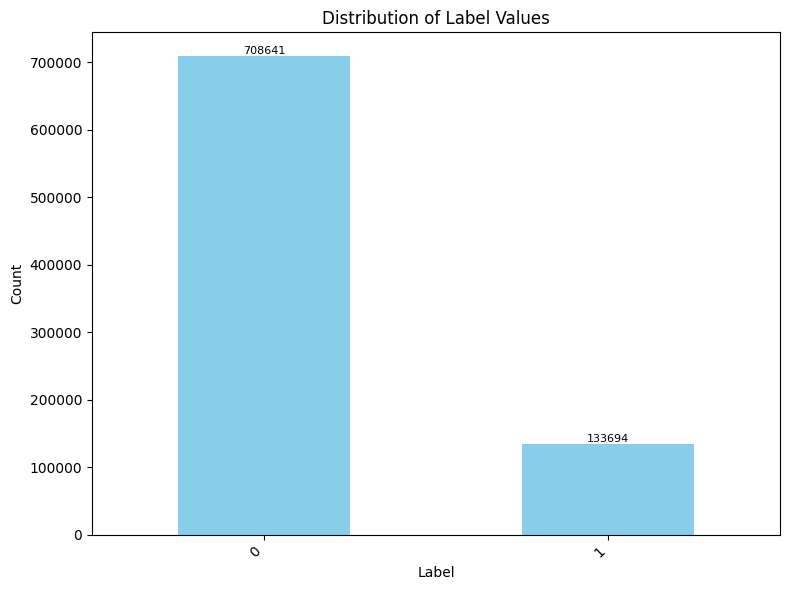

In [7]:
plot_value_counts(data=data, column='Label')

In [8]:
value_counts = data['Label'].value_counts()
class_0_dist_ratio = round(value_counts[0]/(value_counts[0] + value_counts[1]) * 100, 2)
class_1_dist_ratio = round(value_counts[1]/(value_counts[0] + value_counts[1]) * 100, 2)

print('Distribution ratio of label 0: ', class_0_dist_ratio)
print('Distribution ratio of label 1: ', class_1_dist_ratio)

Distribution ratio of label 0:  84.13
Distribution ratio of label 1:  15.87


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


- Above figure shows the distribution of the data labels across the dataset.
- There are 133,694 samples of the hate speech and 708,641 samples that are categorized as not hate speech
- Overall the dataset is imbalanced. Label `0` has 84.13% of the data in the dataset and label `1` has 15.87% of the data

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 842335 entries, 0 to 842334
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Content  842327 non-null  object
 1   Label    842335 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 12.9+ MB


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
data.loc[:, 'Content'].isnull().sum()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


8

In [11]:
data[data['Content'].isnull()==True]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Content,Label
764015,NaN,0
764530,NaN,0
766391,NaN,0
769191,NaN,0
769339,NaN,0
769662,NaN,0
770766,NaN,0
771812,NaN,0


- There are 8 samples that has no content from label 0 in the dataset.
- These samples will be removed later in the preprocessing part

In [12]:
print('Number of duplicated rows: ', data['Content'].duplicated().sum())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Number of duplicated rows:  281950


In [13]:
data[data['Content'].duplicated() ==  True]['Label'].value_counts()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Label
0    241607
1     40343
Name: count, dtype: int64

- There are total of 281,950 duplicated rows according to the value of column Content.
- 241,607 samples belong to class 0 and 40343 belongs to class 1
- These samples will be removed later in the preprocessing part
  

# Data Preprocessing

## Lower casing column names

In [14]:
data.columns = data.columns.str.lower()
print(data.columns)
data.head()

Index(['content', 'label'], dtype='object')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,content,label
0,`- This is not ``creative``. Those are the di...,0
1,` :: the term ``standard model`` is itself le...,0
2,"True or false, the situation as of March 200...",0
3,"Next, maybe you could work on being less cond...",0
4,This page will need disambiguation.,0


## Lower casing all content values

In [15]:
data['content'] = data['content'].str.lower()
data.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,content,label
0,`- this is not ``creative``. those are the di...,0
1,` :: the term ``standard model`` is itself le...,0
2,"true or false, the situation as of march 200...",0
3,"next, maybe you could work on being less cond...",0
4,this page will need disambiguation.,0


## Remove null values

In [16]:
original_shape = data.shape
data.dropna(subset=['content'], inplace=True)
dropped_shape = data.shape
print(f"{original_shape[0] - dropped_shape[0]} rows with missing values are removed")

8 rows with missing values are removed


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Remove duplicated values

In [17]:
data.drop_duplicates(subset=['content'], inplace=True)
print(f'{dropped_shape[0] - data.shape[0]} duplicated rows are removed')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


282395 duplicated rows are removed


## Data distribution after removing duplicates

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


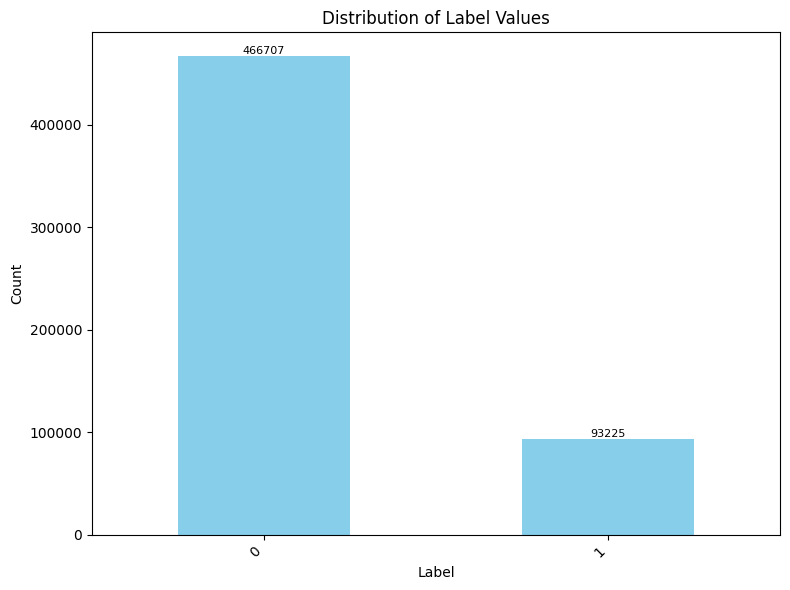

In [18]:
plot_value_counts(data, 'label')

- After removing duplicated data, new distribution of the labels is as follow
  - 466,707 rows from class 0
  - 93,225 rows from class 1

## Remove mentions from texts

In [19]:
def remove_mentions(tweet):
    return re.sub(r'@\w+', '', tweet)

data['content'] = data['content'].apply(remove_mentions)
data.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,content,label
0,`- this is not ``creative``. those are the di...,0
1,` :: the term ``standard model`` is itself le...,0
2,"true or false, the situation as of march 200...",0
3,"next, maybe you could work on being less cond...",0
4,this page will need disambiguation.,0


## Remove links

In [20]:
def remove_urls(tweet):
    return re.sub(r'http\S+|https\S+|www\S+', '', tweet)

data['content'] = data['content'].apply(remove_urls)
data.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,content,label
0,`- this is not ``creative``. those are the di...,0
1,` :: the term ``standard model`` is itself le...,0
2,"true or false, the situation as of march 200...",0
3,"next, maybe you could work on being less cond...",0
4,this page will need disambiguation.,0


## Remove hashtags

In [21]:
def remove_hashtags(tweet):
    return re.sub(r'#\w+', '', tweet)

data['content'] = data['content'].apply(remove_hashtags)
data.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,content,label
0,`- this is not ``creative``. those are the di...,0
1,` :: the term ``standard model`` is itself le...,0
2,"true or false, the situation as of march 200...",0
3,"next, maybe you could work on being less cond...",0
4,this page will need disambiguation.,0


## Apply contraction

In [22]:
data['content'] = data['content'].apply(contractions.fix)
data.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,content,label
0,`- this is not ``creative``. those are the di...,0
1,` :: the term ``standard model`` is itself le...,0
2,"true or false, the situation as of march 200...",0
3,"next, maybe you could work on being less cond...",0
4,this page will need disambiguation.,0


- Contraction converts words like "It's" to its original expanded form "It is"
- This part was important to be done before removing punctuation as removing punctuation can directly effect the process of contraction
- E.g. row indexed 1, had "it's" after :: If" which is now converted to "it is"

## Remove non-alphabetic characters

In [23]:
def clean_text(tweet):
    cleaned_text = re.sub(r'[^a-zA-Z\s]', '', tweet)
    return cleaned_text

data['content'] = data['content'].apply(clean_text)
data.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,content,label
0,this is not creative those are the dictionar...,0
1,the term standard model is itself less npov...,0
2,true or false the situation as of march was...,0
3,next maybe you could work on being less conde...,0
4,this page will need disambiguation,0


## Lemmatizing

In [24]:
# Google Colab V100 = 3m 54s
def lemmatizing_words(tweet):
    lemmatizer = WordNetLemmatizer()
    words = word_tokenize(tweet)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

data.loc[:, ['content']] = data.loc[:, 'content'].swifter.apply(lemmatizing_words)
data.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Pandas Apply:   0%|          | 0/559932 [00:00<?, ?it/s]

,content,label
0,this is not creative those are the dictionary ...,0
1,the term standard model is itself le npov than...,0
2,true or false the situation a of march wa such...,0
3,next maybe you could work on being le condesce...,0
4,this page will need disambiguation,0


- Lemmatizing is converting words into their root format. E.g. "works" is converted to "work"
- Stemming could have been also used but since lemmatizing has shown better accuracy of converting words to their original root compare to stemming, we decided to use lemmatizing instead. Below is an example table of the conversion problems with stemming and how it is handled by lemmatizing

| Original Word  | Lemmatization  | Stemming    |
|-----------------|----------------|-------------|
| **Jumps**       | Jump           | Jump        |
| **Happily**     | Happy          | Happi       |
| **Quickly**     | Quick          | Quick       |
| **Beautifully** | Beautiful      | Beauti      |
| **Discoveries** | Discovery      | Discoveri   |
| **Libraries**   | Library        | Librari     |
| **Universally** | Universal      | Univers     |
| **Machines**    | Machine        | Machin      |
| **Harmonizing** | Harmonize      | Harmon      |
| **Paintings**   | Painting       | Paint       |
| **Unhappily**   | Unhappy        | Unhappi     |

- As you can see Stemming has problems when converting the word to its root. Especially, when root has been changed more than just adding a 's' as plural form
- Lemmatizing has also some problems like this specially with the superlative adjectives like better but we decided to accept this at this point

## Removing stop words

In [25]:
# Google Colab V100 = 3m 37s
def remove_stopwords(tweet):
    stop_words = set(stopwords.words('english'))
    stop_words.discard('not')
    words = nltk.word_tokenize(tweet)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

data['content_cleaned'] = data['content'].swifter.apply(remove_stopwords)
print(data.shape)
data.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Pandas Apply:   0%|          | 0/559932 [00:00<?, ?it/s]

(559932, 3)


,content,label,content_cleaned
0,this is not creative those are the dictionary ...,0,not creative dictionary definition term insura...
1,the term standard model is itself le npov than...,0,term standard model le npov think would prefer...
2,true or false the situation a of march wa such...,0,true false situation march wa saudi proposal l...
3,next maybe you could work on being le condesce...,0,next maybe could work le condescending suggest...
4,this page will need disambiguation,0,page need disambiguation


- Stop words are the words that bring no value to the models later to understand the text.
- We used `nltk` to remove predefined stop words from the contents
- However, in stop words of nltk, `not` is also added. Since `not` can change the meaning of the content, we decided to exclude it from the stop words

## Remove too short and too long contents

- At this moment, we cleaned thee data and ended up with 559,932 samples in the dataset.
- Since there are content that became too short, we will remove those samples that are less than `MIN_CHARS` value specified at the beginning of the code
- For this project we decided to go with 200 as the value of the `MIN_CHARS`. This will result is giving longer content values to the models to do the predictions

In [26]:
def remove_tweets_outside_length_range(df, min_tweet_length=MIN_CHARS, max_tweet_length=MAX_CHARS):
    mask = (df['content_cleaned'].apply(len) >= min_tweet_length) & (df['content_cleaned'].apply(len) <= max_tweet_length)
    return df[mask]

filtered_data = remove_tweets_outside_length_range(data, min_tweet_length=50, max_tweet_length=280)
print(filtered_data.shape)
filtered_data.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(278030, 3)


,content,label,content_cleaned
2,true or false the situation a of march wa such...,0,true false situation march wa saudi proposal l...
3,next maybe you could work on being le condesce...,0,next maybe could work le condescending suggest...
5,important note for all sysops there is a bug i...,0,important note sysops bug administrative move ...
6,i removed the following all name of early poli...,0,removed following name early polish ruler fict...
8,my apology i am english i watch cricket i know...,0,apology english watch cricket know nothing may...


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


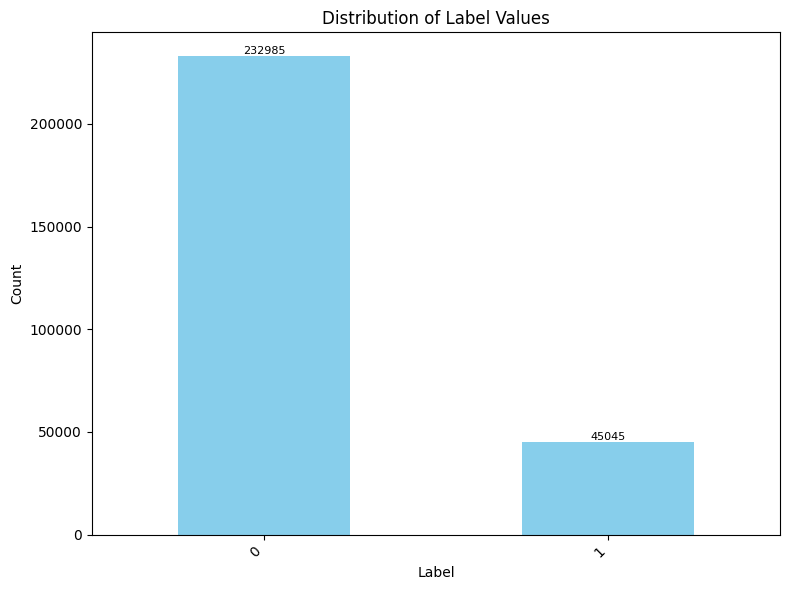

In [27]:
plot_value_counts(filtered_data, 'label')

- After removing sample lower than the minimum character threshold, 131,330 total samples left in the dataset.
- Distribution of labels across dataset:
  - label 0: 9,534
  - label 1: 121,796

## Generate Balanced Data

- In order to have a balanced and smaller dataset compare to the original dataset, we will take equal number of data from each label for the next steps

In [28]:
def sample_dataframe(df, target_column, num_samples_per_class=500, random_state=1):
    sampled_dfs = [
        df[df[target_column] == target_value].sample(n=num_samples_per_class, random_state=random_state)
        for target_value in df[target_column].unique()
    ]

    total_samples = num_samples_per_class * len(df[target_column].unique())
    sampled_df = pd.concat(sampled_dfs, ignore_index=True)
    sampled_df = sampled_df.sample(n=total_samples, random_state=random_state)

    return sampled_df

df = sample_dataframe(filtered_data, 'label', num_samples_per_class=SAMPLES_PER_CLASS)
df.reset_index(inplace=True, drop=True)
print(df.shape)
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(18000, 3)


,content,label,content_cleaned
0,i doubt that i use the same tone on editor who...,0,doubt use tone editor violate blp others disgu...
1,russia confirms syrian refugee proposal sent t...,0,russia confirms syrian refugee proposal sent u...
2,fuck me by this estimate there is at least bil...,0,fuck estimate least billion jew planet guy way...
3,commentator i must be missing something becaus...,0,commentator must missing something section ing...
4,the vile creature is trying to portray herself...,1,vile creature trying portray fierce bitch time...


## Check distribution

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


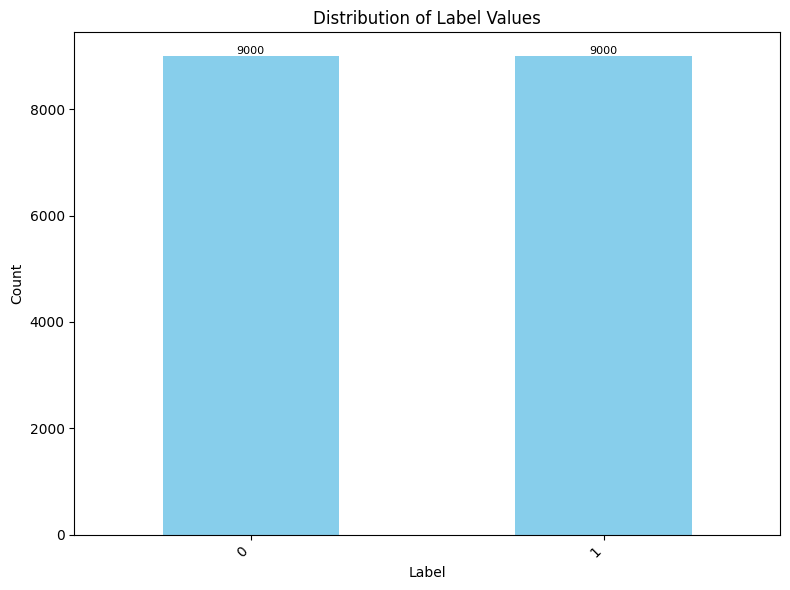

In [29]:
plot_value_counts(df, 'label')

- Now we have equal number of data from each classes to feed our model.
- This solves the imbalanced problem of the original dataset.
- Since the imbalanced problem is solved, we can decide on the evaluation metric of the models. In this case, accuracy score will be focused on for the model evaluation. However, classification report will be generated to have a brief look at other metrics as well.
- From this point, we are going to do the final steps of preprocessing

## Separete hate speech data from not hate speech for Topic Modeling part

In [30]:
def topic_modeling_clean_text(text_column):
    # Removing the word 'not' from the cleaned content
    text_column = text_column.apply(lambda x: ' '.join([word for word in x.split() if word.lower() != 'not']))

    # Removing words less than 3 characters from the cleaned content
    text_column = text_column.apply(lambda x: ' '.join([word for word in x.split() if len(word) >= 3 and word.isalpha()]))

    return text_column
hate_speech_data = df[df['label'] == 1]

# Assuming 'hate_speech_data' is the name of your DataFrame and 'content_cleaned' is the text column
hate_speech_data['content_cleaned'] = topic_modeling_clean_text(hate_speech_data['content_cleaned'])


not_hate_speech_data = df[df['label'] == 0]
not_hate_speech_data['content_cleaned'] = topic_modeling_clean_text(not_hate_speech_data['content_cleaned'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-30-e3f066ff4147>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hate_speech_data['content_cleaned'] = topic_modeling_clean_text(hate_speech_data['content_cleaned'])
<ipython-input-30-e3f066ff4147>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

## Separate contents from lables

In [31]:
X = df.loc[:, 'content_cleaned']
y = df.loc[:, 'label']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Splitting the dataset into train, and test sets
- Train set will be used in the model training
- Test set will be used as the final model evaluation set

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
print('Number of samples in train set: ', X_train.shape[0])
print('Number of samples in test set: ', X_test.shape[0])

Number of samples in train set:  14400
Number of samples in test set:  3600


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Feature extraction using TF-IDF

In [34]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Vectorizing all contents
data_to_list = df['content'].tolist()
X_tfidf = vectorizer.fit_transform(data_to_list)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


- TF-IDF is the multiplication of two different scores. The first one is the score that is calculated by TF which measures how often a phrase appears in the text. The second score is the IDF which is how important the phrase is.

# Sentiment Analysis

- At this part, we want to investigate general language used in the content.
- As we are dealing with hate speech recognition task, we would expect negative language usage in hate speech contents and positiv or neutral language in not hate speech contents.
- However, it is necessary to mention that neither classes, necessarily needs to be identified as expected. In the normal life, it is possible that impolite language is used to express feeling but not hate speech and also vise versa.

In [35]:
def batch_use_hugging_face_model(encoded_inputs, model, config):
    output = model(**encoded_inputs)
    scores = softmax(output.logits.detach().cpu().numpy(), axis=1)
    ranking = np.argsort(scores, axis=1)[:, ::-1]

    results_list = [dict() for _ in range(len(encoded_inputs['input_ids']))]

    for i in range(len(encoded_inputs['input_ids'])):
        for j in range(scores.shape[1]):
            class_label = config.id2label[ranking[i][j]]
            score = scores[i][ranking[i][j]]
            results_list[i][class_label] = score

    return [next(iter(results)) for results in results_list]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
# Google Colab v100 = 2m 43s
# Move model loading outside the loop
tokenizer = AutoTokenizer.from_pretrained(SENTIMENT_MODEL)
config = AutoConfig.from_pretrained(SENTIMENT_MODEL)
config.pooler_dense = None
model = AutoModelForSequenceClassification.from_pretrained(SENTIMENT_MODEL).to(DEVICE)

# Tokenize and pad the input texts outside the loop
max_seq_length = 512  # or any suitable value
encoded_inputs = tokenizer(df['content'].tolist(), return_tensors='pt', padding=True, truncation=True, max_length=max_seq_length).to(DEVICE)

batch_size = 15
num_samples = len(encoded_inputs['input_ids'])
results = []

for start in tqdm(range(0, num_samples, batch_size), desc="Processing Batches", unit="batch"):
    end = min(start + batch_size, num_samples)
    batch_inputs = {key: value[start:end] for key, value in encoded_inputs.items()}
    batch_results = batch_use_hugging_face_model(batch_inputs, model, config)
    results.extend(batch_results)

# Ensure the results are in the same order as the original DataFrame
results_with_indices = list(zip(df.index, results))
sorted_results = [result for index, result in sorted(results_with_indices, key=lambda x: x[0])]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Processing Batches: 100%|██████████| 1200/1200 [02:43<00:00,  7.35batch/s]


In [37]:
df['sentiment'] = results
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,content,label,content_cleaned,sentiment
0,i doubt that i use the same tone on editor who...,0,doubt use tone editor violate blp others disgu...,negative
1,russia confirms syrian refugee proposal sent t...,0,russia confirms syrian refugee proposal sent u...,negative
2,fuck me by this estimate there is at least bil...,0,fuck estimate least billion jew planet guy way...,negative
3,commentator i must be missing something becaus...,0,commentator must missing something section ing...,negative
4,the vile creature is trying to portray herself...,1,vile creature trying portray fierce bitch time...,negative


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


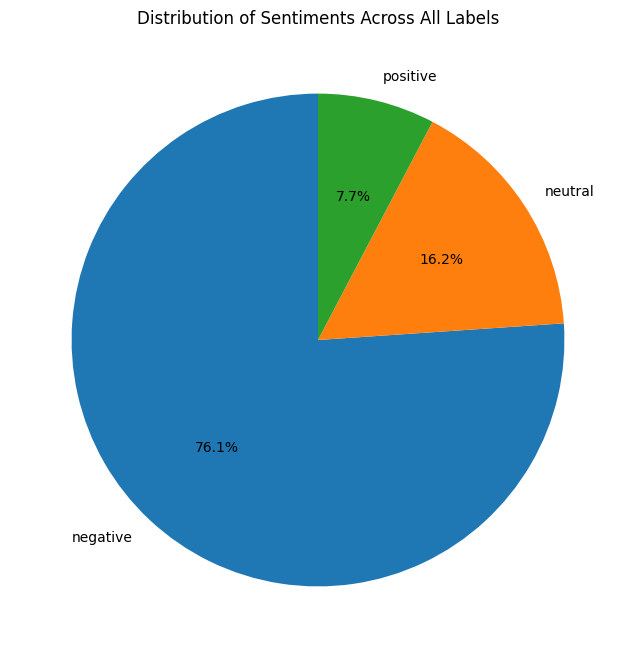

In [38]:
# Count the occurrences of each sentiment
sentiment_counts = df['sentiment'].value_counts()

# Plotting
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90)
ax.set_title('Distribution of Sentiments Across All Labels')
plt.show()

- Result of the sentiment analysis shows that the majority of contents are using negative language for both hate speech contents and not hate speech contents.
- This shows that our initial assumption could be wrong and the case mentioned earlier is applied in here. That means although the language used in the content is not positive but the content is not hate speech

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


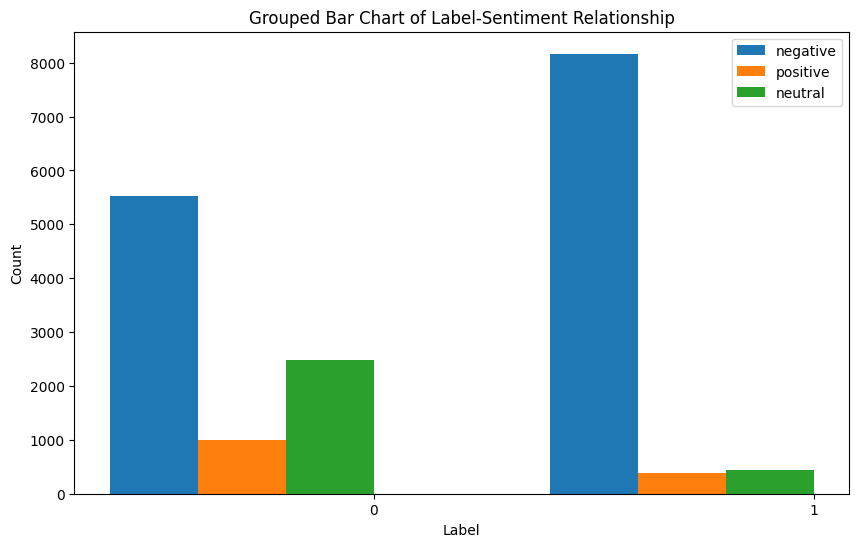

In [39]:
# Count the occurrences of each combination of label and sentiment
counts = df.groupby(['label', 'sentiment']).size().unstack()

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.2
labels = df['label'].unique()

for i, sentiment in enumerate(df['sentiment'].unique()):
    positions = np.arange(len(labels)) + i * bar_width
    ax.bar(positions, counts[sentiment], bar_width, label=sentiment)

ax.set_xticks(positions + bar_width / 2)
ax.set_xticklabels(labels)
ax.set_xlabel('Label')
ax.set_ylabel('Count')
ax.set_title('Grouped Bar Chart of Label-Sentiment Relationship')
ax.legend()

plt.show()

- Above plot shows clearly that the negative language is used mostly in the not hate speech contetnts.
- Also we can see that the positive language and neural language is used in both classes but in the not hate speech contetnt, we can see that there are more which kind of makes sense.
- Also, negative language is widely used in the hate speech contents. Almost all of hate speech contents used negative language to express the content.
- As final result, sentiment analysis alone is not sufficient in hate speech recognition task.

# Topic Modeling

- At this part, topic modeling technique will be used to extract topics from the contents.
- Topic modeling helps us to understand the relationship between hate speech or not hate speech contents with each other as well as identifying keywords used in each topic

In [40]:
def generate_ldavis(df, text_column, max_topics=5):
    # Tokenize the cleaned content
    tokenized_text = [nltk.word_tokenize(text) for text in df[text_column]]

    # Create a dictionary representation of the documents.
    dictionary = corpora.Dictionary(tokenized_text)

    # Convert the tokenized documents into a document-term matrix
    corpus = [dictionary.doc2bow(text) for text in tokenized_text]

    # Build the LDA model
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=max_topics,
                                           passes=15)

    # Print the topics and their representative words
    topics = lda_model.print_topics(num_words=5)
    topics_string_list = list()

    for topic in topics:
        topic_id, words = topic
        topics_list = [word.split('*')[1].strip().strip('"') for word in words.split('+')]
        topics_string = ', '.join(topics_list)
        topics_string_list.append(topics_string)

    # Visualize the topics
    vis_data = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=False, n_jobs=1)
    return pyLDAvis.display(vis_data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Topic modeling for hate speech data

In [41]:
generate_ldavis(hate_speech_data, 'content_cleaned', max_topics=10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


- The above visualization shows the 10 extracted topics from the hate speech data.
- On the right side, we can see the most used keywords in the whole hate speech data.
- looking at the keywords, we can roughly guess the context of the hate speech.
- It's also clear that in hate speech swear words and general hate speech contexts words are included.
- On the left side, position of bubbles tell us that topics 7, 2, 10, 8, and 6 are close to each other. Therefore, context of these topics are similar to each other in general.
- Also we can see that topics 1, 3, and 5 are placed far from others. This represents that context of these topics are different from the others.
- Using the visualization we can also check the frequency of usage of different words. For instance, let's check keyword `woman`. Hovering of this keyword, results in changing size of the bubbles. Size of bubbles 2, 5, and 6 are increased respectively. Bubble 2 has the biggest size that means the word woman is used more in topic 2 compare to the other topics.
- Additionally for `black`, topic 5 is increased significantly. This shows that more content about this keyword is existing in this topic

## Topic modeling for NOT hate speech data

In [42]:
generate_ldavis(not_hate_speech_data, 'content_cleaned', max_topics=10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


- Topic modeling on the not hate speech data has significant difference compare to hate speech.
- Looking at the most frequent keywords used in the topics, we can say that there are significantly less swear words included.
- After checking most frequent used keywords in different topics, we confirm the difference between the language used in these context overall.

# Classification Model
- Now that we have better understanding about the nature of the hate speech, we can train machine learning models to identify hate speech from not hate speech contents

In [43]:
def plot_confusion_matrix(y_test, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
    disp.plot(cmap=plt.cm.Blues, values_format=".0f")
    plt.title(title)
    plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Multinomial Naive Bays

### Tuning hyper-parameters

In [44]:
def tune_hyperparameters(classifier, params, X_train, y_train, cv=5):
    grid_search = GridSearchCV(classifier, params, cv=cv, verbose=3, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_score_, grid_search.best_params_

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [45]:
mnb_params = {
    'alpha': [0, 0.1, 0.5, 0.8, 1.0, 1.5, 1.8, 2.0, 2.5, 3.0],
    'fit_prior': [True, False],
    'force_alpha': [True, False],
}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [46]:
mnb_classifier = MultinomialNB()
mnb_best_score, mnb_best_params = tune_hyperparameters(mnb_classifier, mnb_params, X_train_tfidf, y_train)
print('Best score: ', mnb_best_score)
print('Best parameters: ', mnb_best_params)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be remo

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best score:  0.810763888888889
Best parameters:  {'alpha': 2.5, 'fit_prior': False, 'force_alpha': True}


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


### Train model with tuned-parameters

In [47]:
mnb_best_classifier = MultinomialNB(**mnb_best_params)
mnb_best_classifier.fit(X_train_tfidf, y_train)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


MultinomialNB(alpha=2.5, fit_prior=False, force_alpha=True)

### Model prediction

In [48]:
y_pred_mnb = mnb_best_classifier.predict(X_test_tfidf)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Model evaluation

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be remo

              precision    recall  f1-score   support

           0       0.82      0.78      0.80      1785
           1       0.79      0.83      0.81      1815

    accuracy                           0.80      3600
   macro avg       0.80      0.80      0.80      3600
weighted avg       0.80      0.80      0.80      3600



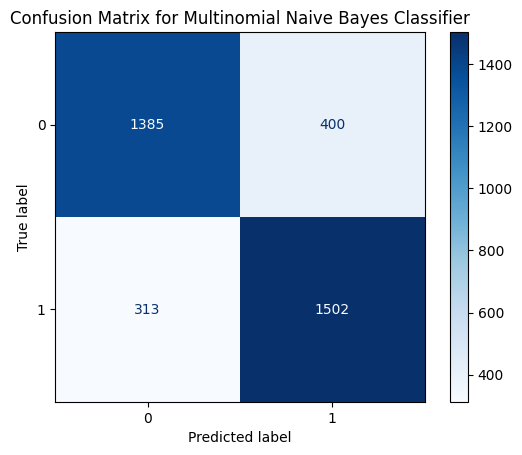

In [49]:
print(classification_report(y_test, y_pred_mnb))
plot_confusion_matrix(y_test, y_pred_mnb, title='Confusion Matrix for Multinomial Naive Bayes Classifier')

- Prediction result for the Mutlinomial Naive Bays machine learning model is not bad. Accuracy of 80% is pretty good result for the model.
- f1-score, for both labels zero and one, is also ~81%. This is a really good sign. It shows that the model is not biased towards one class at the expense of the others. In another word, this shows that model learnt great from the trained data and showed a great performance on the test dataset.
- Confustion matrix also shows that there are relatively a few data samples miss categorized.
- Additionaly, it shows that difference between mis-classified data from different labels is not high at all

## Support Vector Classifier
- let's try another popular machine learning algorithm. Support Vector Classifier is one the most popular and used machine learning algorithms used for Natural Language Processing.

### Tuning hyper-parameters
- As tuning all hyper parameters takes very long time, we tune only two main parameter for tuning.

In [50]:
svm_params = {
    'C': [0.1, 0.5, 1.0, 1.5, 2.0, 2.5],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [51]:
svc_best_score, svc_best_params = tune_hyperparameters(
    SVC(),
    svm_params,
    X_train_tfidf,
    y_train
)
print('Best score: ', round(svc_best_score, 2))
print('Best parameters: ', svc_best_params)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be remo

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Best score:  0.82
Best parameters:  {'C': 1.5, 'kernel': 'rbf'}


### Train model with tuned-parameters

In [52]:
best_model = SVC(**svc_best_params)
best_model.fit(X_train_tfidf, y_train)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


SVC(C=1.5)

### Model prediction

In [53]:
y_pred_svc = best_model.predict(X_test_tfidf)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Model evaluation

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be remo

              precision    recall  f1-score   support

           0       0.81      0.80      0.81      1785
           1       0.81      0.81      0.81      1815

    accuracy                           0.81      3600
   macro avg       0.81      0.81      0.81      3600
weighted avg       0.81      0.81      0.81      3600



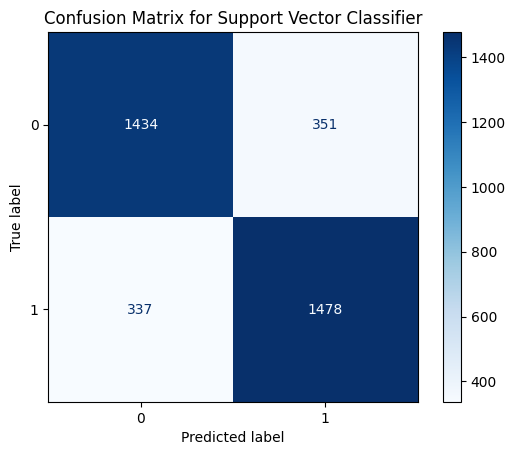

In [54]:
print(classification_report(y_test, y_pred_svc))
plot_confusion_matrix(y_test, y_pred_svc, title='Confusion Matrix for Support Vector Classifier')

- SVC model also performed good. The accuracy of the model on the test set is 81% which is 1% more than Multinomial Naive Bays model.
- The f1-score for SVC is slightly better than MNB model for idnetifying not hate speech content.
- It is clear that differnce between the miss matched data for different classes is lower than MNB model. Which should be since the accuracy and f1-score is slightly higher
- The difference between the accuracy of the two models is not significant at all. Since the the evaluation results are closely the same, we would like to include the training time it tool for the two models as the final evaluation.
- Summary of the execution time:

**SVC**
- Parameter Tuning: 12m
- Training best estimator: 1m

**MNB**
- Parameter Tuning: 2s
- Training best estimator: 1s

- Since Multinomial Naive Bays model finished executions much faster than SVC, we would like to propose the Multinomial model for the classification.

# Future work
- Applying further preprocessing on the data and using differnt vectorizing model could directly effect the performance and results of the all three major steps in this project. Therefore, we highly suggest to try other approaches to potentially increase the quality of the results and findings
- In the sentiment analysis section, there are several other sentiment analysis specific models available. Trying out other models could also result is better findings.
- In the topic modeling, there can be several other investigations applied. For instance using other topic model, using keywords extracted by model to identify trends in other topics, and so on.
- In the classification section, as there are several machine learning models available, we only focused on two of them. Deep learning can also be implemented to enhance the result. Additionally, For SVC model, there are some other parameters that can be tuned. We suggest to tune the model with several values for all the available parameters.